In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# import fields as f
# import fields_plot as fp
from pynvcenter import nv_optical_response as nv


import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

%matplotlib inline
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
import matplotlib

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

## summary of the most important functions

`esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)` <br>
calculates the odmr signal for a single NV transition according to 
\begin{equation}
s_i(\omega) = c - (c-c_o)\frac{\gamma^2}{(\omega-\omega_o)^2+\gamma^2},
\end{equation}
where $c$ is the count rate at resonance (i.e. minimum) in kCounts, $c_o$ the count rate of the background (i.e far away from $\omega_o$, $\omega_o$ is the resonance frequency and $\gamma$ the linewidth. Optionally, shot noise is added if `shot_noise` larger than 0. The `shot_noise` is the number corresponds to the measurement time in milliseconds, if the count rate $c_o$, $c$ are given in kCounts.
 <br> <br>


`esr_odmr_signal_ensemble(f, f_esr, contrast, avrg_count_rate=1, linewidth=1e7, shot_noise=0)` <br>
calculates the ensemble odmr according to 
\begin{equation}
s_\text{ens}(\omega) =\sum_i s_i(\omega),
\end{equation}
where $s_i(\omega)$ is the odmr of a single NV transition. The background counts and average count rate needed for $s_i(\omega)$ are calculated with `co, c = contrast_to_count_rates_max(contrast / 100, c)` ($c_o = \frac{1 - \mathcal{C}}{1 + \mathcal{C}} c$)
 <br> <br>



### approach 1 - contrast
`esr_2D_map_ring_scan(use_Pl=False)` <br>
calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. The magnetic field at the NVs is assumed to be generated by a magnetic dipole located at $\mathbf{r}_\text{dp} = (0,0,-h)$. The main parts of the calculation are
1. calculate the magnetic field at each NV position:<br>`bfields`
1. calculate the contast for each NV transition:<br>`esr_contrast = esr_contrast_ensemble(bfields, k_MW=MW_rabi, Dgs=Dgs)`
1. calculate the transtion frequencies for each NV transition:<br>`esr_freq = esr_frequencies_ensemble(bfields, Dgs=Dgs)`
1. calculate the odmr signal:<br>`esr_odmr_signal_ensemble(esr_freq, esr_contrast,avrg_count_rate,linewidth)`
<br><br>

`esr_contrast_ensemble` uses `photoluminescence_contrast()` to calculate the contrast for each NV transition.
<br><br>


`photoluminescence_contrast(Bfield, k12, k13, beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)` calculates the contrast following ref [1] using the level structure below

<img src="Tetienne_Fig1.jpg" width="400">


- There are only five intrinsic parameters, which are the rates kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4 in MHz with values are taken from [1].
- rates k12 (k13) correspoind to the Rabi frequencies between 0 and -1(+1) state in MHz
- $\beta$ is the optical pumping parameter and set to values around 1. Not that this paramter is a free fit parameter and not explicitely given in [1]
- Dgs=2.87 and Des=1.42 are the ground state and excited state zero field splitting
- Note that the singlet states are summarized into a *single metastable* level labelled 7.

The ground state Hamiltonian of the model is 
\begin{equation}
H_\text{gs} = 2\pi \hbar D_\text{gs} S_z^2+g\mu_B \mathbf{B}\cdot\mathbf{S},
\end{equation}
hence it doesn't account for strain splittings.
The excited level spin Hamiltonian $H_\text{es}$ is simply given by equation (3) while replacing $D_\text{gs}$ by $D_\text{es}$.
<br><br>


### approach 2 - PL
`esr_2D_map_ring_scan(use_Pl=True)` <br>
also calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. However, the main parts of the calculation are a little bit different and are: 
1. calculate the magnetic field at each NV position:<br>`bfields`
1. calculate the photoluminescence for each NV transition and the PL background:<br>`esr_PL = esr_PL_ensemble(bfields, k_MW=MW_rabi, Dgs=Dgs)`
1. calculate the transtion frequencies for each NV transition:<br>`esr_freq = esr_frequencies_ensemble(bfields, Dgs=Dgs)`
1. calculate the odmr signal:<br>`esr_odmr_signal_ensemble_PL(esr_freq, esr_pl,background_pl,linewidth)`
<br><br>

### approach 3 - PL2 (slow)
`esr_2D_map_ring_scan(use_Pl=True)` <br>
also calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. However, the main parts of the calculation are a little bit different and are: 
1. calculate the magnetic field at each NV position:<br>`bfields = b_field_single_dipole()`

For each magnetic field (lab frame)
2. calculate the magnetic field in the NV frame for each NV<br>
2. from this field calculate the esr transition frequencies  for each NV<br>
2. calculate the Rabi frequency for each esr transition assuming a Lorenzien centered at the transition frequency with a linewith $\gamma$:<br> `MW_rabi * lorenzian()`
2. for each Rabi frequency calculate the photoluminescence (PL): <br>`photoluminescence()`
<br><br>
[1] Tetienne et al. New Journal of Physics **14** (2012) 103033

## reproduce some figure from the literature

### esr frequencies as a function of azimuthal angle theta

(0, 360)

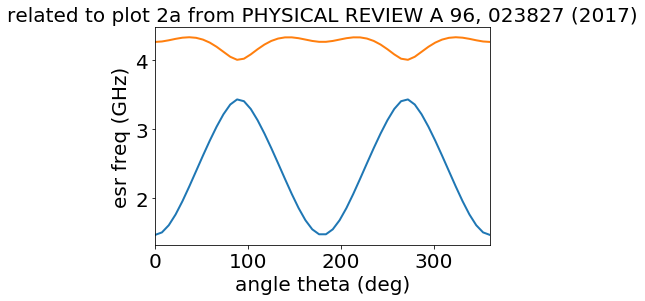

In [36]:
phi = 0
Bo=0.05

thetas = np.linspace(0,2*np.pi,50)

B = np.array([[
    Bo*np.cos(phi)*np.sin(theta),
    Bo*np.sin(phi)*np.sin(theta),
    Bo*np.cos(theta)
    
] for theta in thetas])

for b in nv.esr_frequencies(B).T:
    plt.plot(180/np.pi*thetas, b*1e-9)
    
plt.title('related to plot 2a from PHYSICAL REVIEW A 96, 023827 (2017)')
plt.xlabel('angle theta (deg)')
plt.ylabel('esr freq (GHz)')
plt.xlim([0,360])

### reproduce plot 2b from Tetienne et al.

New Journal of Physics 14 (2012) 103033 (http://www.njp.org/)

Text(0.5,1,'angle to Nv axis 74.0 deg')

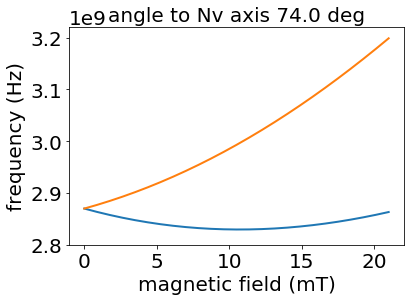

In [38]:
# angle 
theta = 74*np.pi/180
# field strength
B_mag = np.linspace(0,0.021,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T
f = nv.esr_frequencies(Bs)

plt.plot(B_mag*1e3, f[:,0])
plt.plot(B_mag*1e3, f[:,1])
plt.xlabel('magnetic field (mT)')
plt.ylabel('frequency (Hz)')
plt.ylim([2.8e9, 3.22e9])
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### Tetienne Fig. 2a
We don't recover the asymmetry

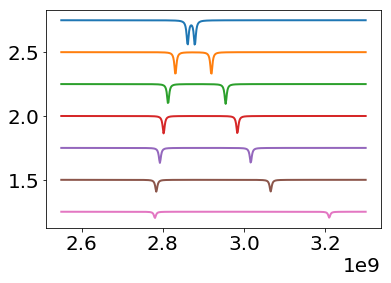

In [60]:
theta = 74*np.pi/180
# field strength
B_mag = np.array([0.8, 4, 6.4, 8.2, 10.1, 12.7, 19.3])*1e-3


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T

f = np.linspace(2.55, 3.3, 501)*1e9

esr_contrast = nv.esr_contrast_ensemble(B_lab=Bs, k_MW=10)

esr_freq = nv.esr_frequencies_ensemble(B_lab=Bs)

esr_contrast.shape, esr_freq

nv_id = 0
for bfield_id in range(len(Bs)):
    odmr  = nv.esr_odmr_signal_ensemble(f, esr_freq[bfield_id, nv_id], esr_contrast[bfield_id, nv_id],
                                        avrg_count_rate=1, linewidth=3e6, shot_noise=0)

    plt.plot(f, odmr+(len(Bs)-bfield_id)/4)
# nv.esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)

### Tetienne Fig. 2c
contrast for 1 and -1 transition

parameters Fig. 2c:
 - for -1 beta = 0.011, k12 = 1.2e+06 s^-1
 - for +1 beta = 0.015, k12 = 2.5e+05 s^-1

Text(0.5,1,'angle to Nv axis 57.0 deg')

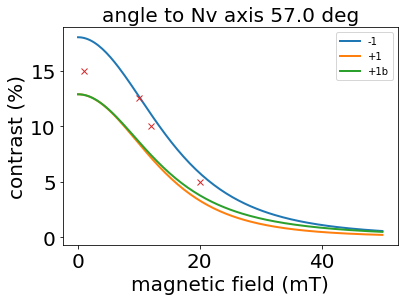

In [39]:
# angle 
theta = 57*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,151)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


Cm = nv.photoluminescence_contrast(Bfield=Bs, k12=1.2, k13=0, beta=0.011)
Cp = nv.photoluminescence_contrast(Bfield=Bs, k12=0.25, k13=0, beta=0.015)
Cp2 = nv.photoluminescence_contrast(Bfield=Bs, k12=0, k13=0.25, beta=0.015)
plt.plot(B_mag*1e3,Cm, label = '-1')
plt.plot(B_mag*1e3,Cp, label = '+1')
plt.plot(B_mag*1e3,Cp2, label = '+1b')

plt.plot([1, 10,12, 20],[15, 12.5,10,5], 'x')
plt.legend()
plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### show the dips at the anticrossing

Text(0.5,1,'angle to Nv axis 1.0 deg')

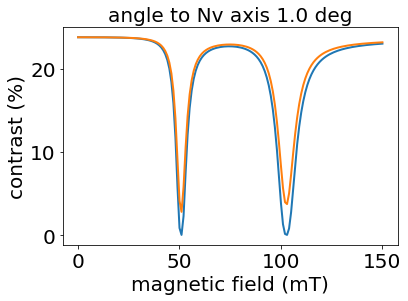

In [11]:
# angle 
theta = 57*np.pi/180
theta = 1*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.15,151)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


Cm = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=1)
Cp = nv.photoluminescence_contrast(Bfield=Bs, k12=0, k13=10, beta=1)
plt.plot(B_mag*1e3,Cm)
plt.plot(B_mag*1e3,Cp)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

Text(0.5,1,'angle to Nv axis 30.0 deg')

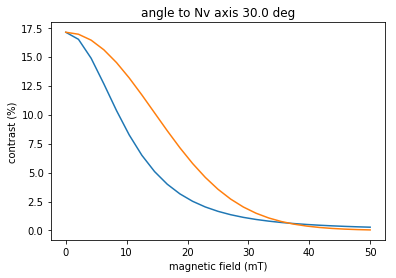

In [3]:
# angle 
# theta = 57*np.pi/180
theta = 74*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))






# angle 
# theta = 57*np.pi/180
theta = 30*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### show contrast change for all four NV families

In [10]:
theta, phi = nv.nNV_angles[0]
theta, phi


(54.735610317244998, 135.0)

Text(0.5,1,'angle to Nv axis 54.7 deg')

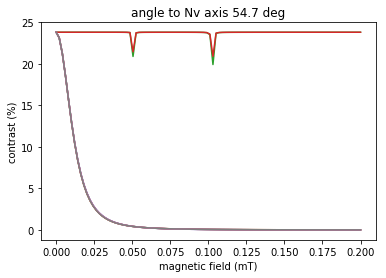

In [11]:
# angle 
# theta = 57*np.pi/180
theta = 54
phi = 0

# check that if the field is aligned with the NV the contrast stays constant
theta, phi = nv.nNV_angles[1]

theta = 54.7 # for small missalignment we get dips at the level crossings
# phi = 0

# convert to radias
theta *= np.pi/180
phi *= np.pi/180
# field strength
B_mag = np.linspace(0,0.20,100)


Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T


for c in np.array([contrast.flatten() for contrast in nv.esr_contrast_ensemble(Bs)]).T:
    plt.plot(B_mag, c)
plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

In [16]:
for i in range(4):
    print(['f%d'%d for d in [i*2, i*2+1]])

['f0', 'f1']
['f2', 'f3']
['f4', 'f5']
['f6', 'f7']


### Tetienne Fig. 4

In [137]:
Bz = np.linspace(0,150, 151)*1e-3
Bperp = np.linspace(0,150, 151)*1e-3

X, Y = np.meshgrid(Bperp, Bz)

In [138]:
Bfield = np.vstack([np.zeros(len(X.flatten())), X.flatten(), Y.flatten()]).T
Bfield.shape

(22801, 3)

In [139]:
transition_rates = nv.transition_rate_matrix(Bfield)

In [140]:
populations = nv.populations(transition_rates)

np.array(transition_rates).shape, np.array(populations).shape

((22801, 7, 7), (22801, 7))

In [141]:
# transition_rates = nv.transition_rate_matrix(Bfield)
# populations = nv.populations(transition_rates)
pl_no_mw = nv.photoluminescence_rate(transition_rates, populations)

Text(0.5,1,'Fig 4a')

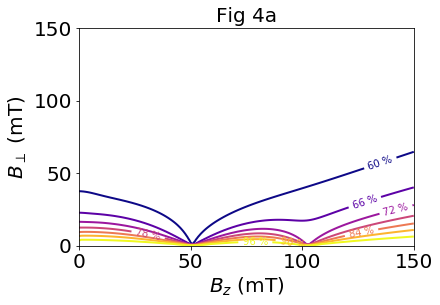

In [143]:
fig, ax = plt.subplots()
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
pl_no_mw = np.array(pl_no_mw).reshape(X.shape)
Z  = pl_no_mw/pl_no_mw.max()
CS = ax.contour(1e3*Y, 1e3*X, 100*Z, cmap='plasma')  # , cmap='hot', viridis

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)



plt.xlabel('$B_z$ (mT)')
plt.ylabel('$B_\perp$ (mT)')
# plt.colorbar()
plt.title('Fig 4a')

Text(0.5,1,'Fig 4a')

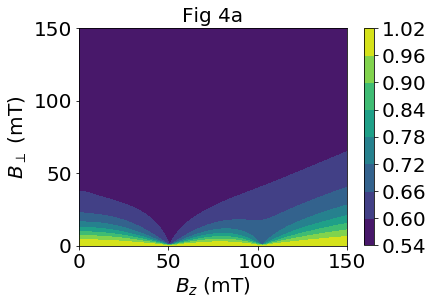

In [129]:
plt.contourf(1e3*Y, 1e3*X, Z/Z.max() )
plt.xlabel('$B_z$ (mT)')
plt.ylabel('$B_\perp$ (mT)')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
plt.colorbar()

plt.title('Fig 4a')

#### compare with data from JP Tetienne

In [28]:
parameters = {
    'beta' : 5000 #   for 60 ps and 0 for 100 ns.  
}  




data_JP = np.loadtxt('../files_from_JP_Tetienne/PL_vs_Bperp_Bpara.txt')

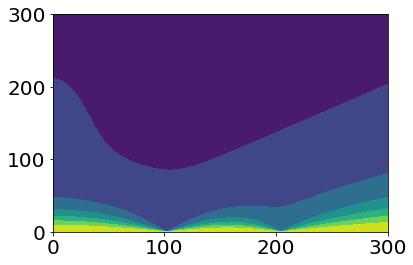

In [33]:
plt.contourf(data_JP.T)

## Comparing contrast vs directly fluorescence

### Single NV
magnetic field is defined in the NV frame, thus theta is the angle with the NV-axis

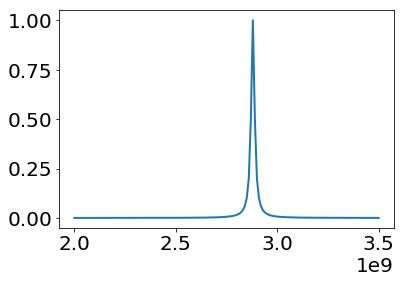

In [144]:

f = np.linspace(2.0, 3.5, 151)*1e9
signal = nv.lorenzian(f, linewidth=10e6, fo=2.88e9)
plt.plot(f, signal)

#### Photoluminescence

In [451]:
MW_rabi =10
linewidth=10e6
fo=2.87e9
beta=1


phi = 10

# convert to radias
phi *= np.pi/180
# field strength
B_mag = 0.020

thetas = np.linspace(0,45,91)


PLm = []
PLp = []
for theta in tqdm(thetas):
    theta *= np.pi/180  # convert to radias
    Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T
    esr_freq = nv.esr_frequencies(np.expand_dims(Bs,0))[0]  # find the transition here the -1
    
    k12 = MW_rabi*lorenzian(f, linewidth=linewidth, fo=esr_freq[0])
    
    PLm.append([nv.photoluminescence(np.expand_dims(Bs,0), k, 0, beta=beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)[0]
               for k in k12])
    k13 = MW_rabi*lorenzian(f, linewidth=linewidth, fo=esr_freq[1])
    
    PLp.append([nv.photoluminescence(np.expand_dims(Bs,0), k, 0, beta=beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)[0]
               for k in k13])
    
    
PLm = np.array(PLm)
PLp = np.array(PLp)

100%|██████████| 91/91 [00:41<00:00,  2.21it/s]


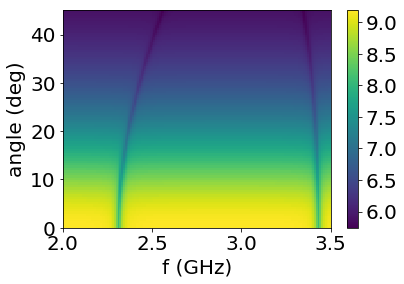

In [452]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, PLm+PLp)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### Contrast

In [453]:
sm = []
sp = []
for theta in thetas:
    
    theta *= np.pi/180
    Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T
    
    
    esr_contrast = [nv.photoluminescence_contrast(np.expand_dims(Bs,0), k12=MW_rabi, k13=0, beta=beta)[0],
                    nv.photoluminescence_contrast(np.expand_dims(Bs,0), k12=0, k13=MW_rabi, beta=beta)[0]]
    esr_freq = nv.esr_frequencies(np.expand_dims(Bs,0))[0]
#     esr_contrast = nv.esr_contrast_ensemble(np.expand_dims(Bs,0), k_MW=MW_rabi)
#     esr_freq = nv.esr_frequencies_ensemble(np.expand_dims(Bs,0))
    
    
    
    co, c1 = nv.contrast_to_count_rates_max(esr_contrast[0] / 100, c1=4.5)
    sm.append(nv.esr_odmr_signal(f, co, c1, linewidth=linewidth, fo=esr_freq[0]))

    co, c1 = nv.contrast_to_count_rates_max(esr_contrast[1] / 100, c1=4.5)
    sp.append(nv.esr_odmr_signal(f, co, c1, linewidth=linewidth, fo=esr_freq[1]))


sm = np.array(sm)
sp = np.array(sp)







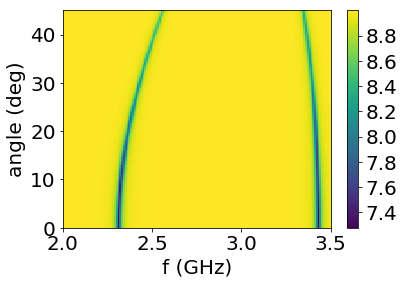

In [454]:
plt.pcolor(X*1e-9, Y, sm+sp)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### compare the two in a cross cut

conclusion: the PL signal is lower and has less contrast!!

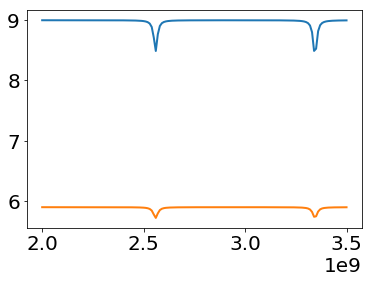

In [455]:
idx = 90
for s in [(sm+sp)[idx], (PLm+PLp)[idx]]:

#     plt.plot(f, s / s.max())
    plt.plot(f, s )

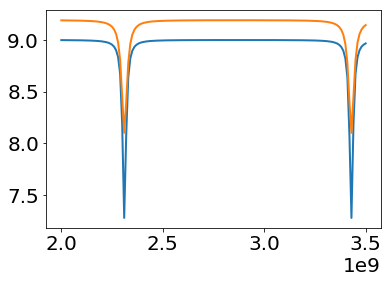

In [456]:
idx = 0
for s in [(sm+sp)[idx], (PLm+PLp)[idx]]:

#     plt.plot(f, s / s.max())
    plt.plot(f, s )

### Ensemble

now we define the field in the lab frame, hence theta is the angle to the z-axis

#### Contrast method

In [13]:
MW_rabi =10
linewidth=10e6
fo=2.87e9
beta=1


phi = 10

# convert to radias
phi *= np.pi/180
# field strength
B_mag = 0.020

thetas = np.linspace(0,45,91)
f = np.linspace(2.0, 3.5, 151)*1e9

In [14]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal_c = nv.signal_contrast(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, avrg_count_rate=4.5, linewidth=linewidth, shot_noise=0)

CPU times: user 1.72 s, sys: 19.7 ms, total: 1.74 s
Wall time: 1.82 s


In [15]:
Z = signal_c/signal_c.max() + 0.005*np.random.randn(*signal_c.shape)


In [17]:
esr_freq = nv.esr_frequencies_ensemble(Bs)

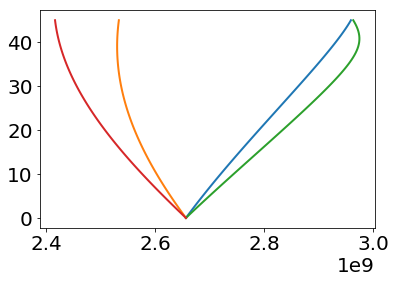

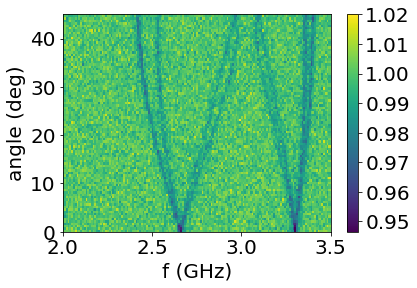

In [24]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)

# for l in esr_freq[:,:,0].T:
#     plt.plot(l*1e-9,thetas, 'w--')

# for l in esr_freq[:,:,1].T:
#     plt.plot(l*1e-9,thetas, 'w--')
    
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### photoluminescence

In [185]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal = nv.signal_photoluminescence(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, linewidth=linewidth, shot_noise=0)


CPU times: user 1.21 s, sys: 11 ms, total: 1.23 s
Wall time: 1.24 s


In [186]:
f.shape, signal.shape

((151,), (91, 151))

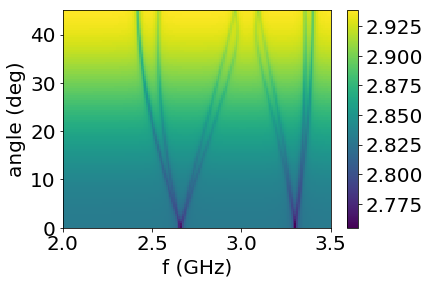

In [187]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, signal)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

adding noise

In [188]:
Z = signal/signal.max() + 0.005*np.random.randn(*signal.shape)

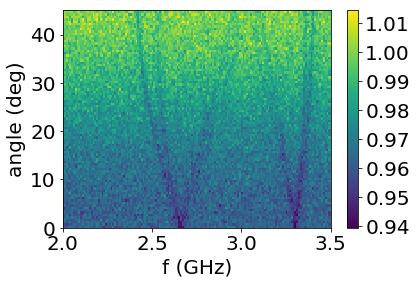

In [189]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

normalize each row

In [190]:
np.tile([1,2,3],2)

array([1, 2, 3, 1, 2, 3])

In [191]:
X = np.vstack([[1,2,3,4],[1,2,3,4]]).T
print(X.shape)
X.flatten()

(4, 2)


array([1, 1, 2, 2, 3, 3, 4, 4])

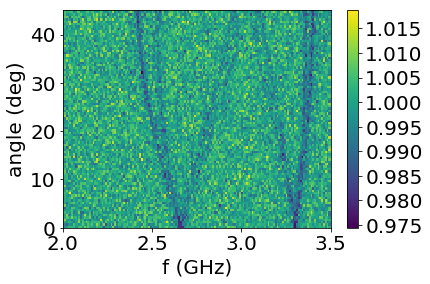

In [192]:

# Z=signal / np.tile(signal.mean(axis=1), (signal.shape[1],1)).T


Z=Z / np.tile(Z.mean(axis=1), (Z.shape[1],1)).T

X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### photoluminescence - 2 (slow)

In [12]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal = nv.signal_photoluminescence_2(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, linewidth=linewidth, shot_noise=0)

NameError: name 'f' is not defined

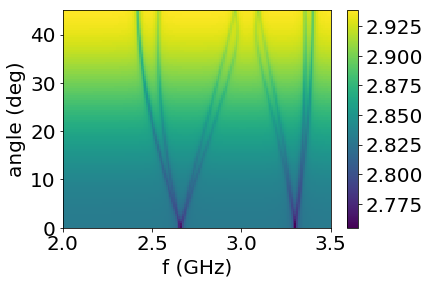

In [184]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, signal)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

## playing around

CPU times: user 301 ms, sys: 6.31 ms, total: 307 ms
Wall time: 331 ms


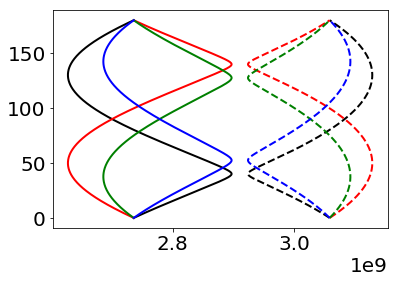

In [26]:
%%time
thetas = np.linspace(0,180,361)
phi=15
B_mag = 0.01

p = phi*180/np.pi
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(p), B_mag*np.sin(t)*np.sin(p), B_mag*np.cos(t)]).T
esr_freqs = nv.esr_frequencies_ensemble(Bs)

for l, c in zip(esr_freqs[:,:,0].T, ['k', 'r', 'g', 'b']):
    plt.plot(l, thetas, c)
for l, c in zip(esr_freqs[:,:,1].T, ['k', 'r', 'g', 'b']):
    plt.plot(l, thetas, c+'--')

In [4]:
esr_freqs

array([[[2.65665759e+09, 3.29867034e+09],
        [2.65665759e+09, 3.29867034e+09],
        [2.65665759e+09, 3.29867034e+09],
        [2.65665759e+09, 3.29867034e+09]],

       [[2.64633321e+09, 3.30390090e+09],
        [2.66702773e+09, 3.29332005e+09],
        [2.65651788e+09, 3.29874175e+09],
        [2.65692499e+09, 3.29853360e+09]],

       [[2.63606042e+09, 3.30901164e+09],
        [2.67743780e+09, 3.28785027e+09],
        [2.65650596e+09, 3.29874785e+09],
        [2.65731993e+09, 3.29833152e+09]],

       ...,

       [[2.67743780e+09, 3.28785027e+09],
        [2.63606042e+09, 3.30901164e+09],
        [2.65731993e+09, 3.29833152e+09],
        [2.65650596e+09, 3.29874785e+09]],

       [[2.66702773e+09, 3.29332005e+09],
        [2.64633321e+09, 3.30390090e+09],
        [2.65692499e+09, 3.29853360e+09],
        [2.65651788e+09, 3.29874175e+09]],

       [[2.65665759e+09, 3.29867034e+09],
        [2.65665759e+09, 3.29867034e+09],
        [2.65665759e+09, 3.29867034e+09],
        [2.

In [217]:
Bs

array([[-0.00000000e+00,  0.00000000e+00,  2.00000000e-02],
       [-2.51621044e-04,  2.41912063e-04,  1.99969539e-02],
       [-5.03165443e-04,  4.83750437e-04,  1.99878165e-02],
       [-7.54556572e-04,  7.25441456e-04,  1.99725907e-02],
       [-1.00571786e-03,  9.66911498e-04,  1.99512810e-02],
       [-1.25657279e-03,  1.20808701e-03,  1.99238940e-02],
       [-1.50704496e-03,  1.44889453e-03,  1.98904379e-02],
       [-1.75705806e-03,  1.68926070e-03,  1.98509230e-02],
       [-2.00653596e-03,  1.92911230e-03,  1.98053614e-02],
       [-2.25540264e-03,  2.16837628e-03,  1.97537668e-02],
       [-2.50358230e-03,  2.40697975e-03,  1.96961551e-02],
       [-2.75099935e-03,  2.64485003e-03,  1.96325437e-02],
       [-2.99757841e-03,  2.88191466e-03,  1.95629520e-02],
       [-3.24324439e-03,  3.11810144e-03,  1.94874013e-02],
       [-3.48792244e-03,  3.35333841e-03,  1.94059145e-02],
       [-3.73153804e-03,  3.58755392e-03,  1.93185165e-02],
       [-3.97401697e-03,  3.82067663e-03